# Audio filtering, FIR and IIR

Diego Torres
Philippe Massouf

In [1]:
import numpy as np

from scipy.io.wavfile import read
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import freqz
import IPython.display as ipd

import matplotlib.pyplot as plt

In [2]:
sr, audio = read('../H1/string_1.wav')

## FIR delay

In [3]:
DELAY = 10 # in frames
ALPHA = 0.5

In [4]:
def delay_filter_fir(audio, delay=DELAY, alpha=ALPHA):
    # We add zeros to the beginning of the delayed audio
    new_audio = audio + alpha*np.concatenate([np.zeros(delay), audio[:-delay]])
    return new_audio

### 1. Impulse response

Under the framework of FIR filters, given by the following equation:

$$
y[t] = \sum_{n=0}^{K-1} h[n]x[t-n]
$$

the filter $s[t] = e[t] + \alpha e[t-D]$, corresponds to an impulse of size $K=D+1$ with values

$$
h[n] = \begin{cases} 
1 & \text{if } n = 0, \\
\alpha & \text{if } n = D, \\
0 & \text{otherwise.}
\end{cases}
$$

We can confirm this numerically by inputting the Dirac delta into the filter

In [5]:
# Constructing the delta
delta = np.zeros(len(audio))
delta[0] = 1

In [6]:
impulse_response = delay_filter_fir(delta)

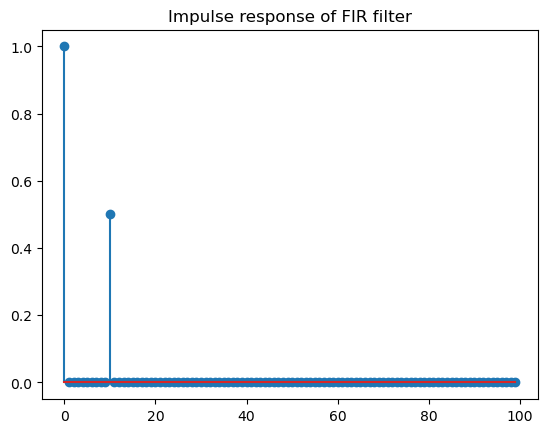

In [7]:
plt.stem(impulse_response[:100])
plt.title('Impulse response of FIR filter')
plt.show()

In [8]:
delay = delay_filter_fir(audio)

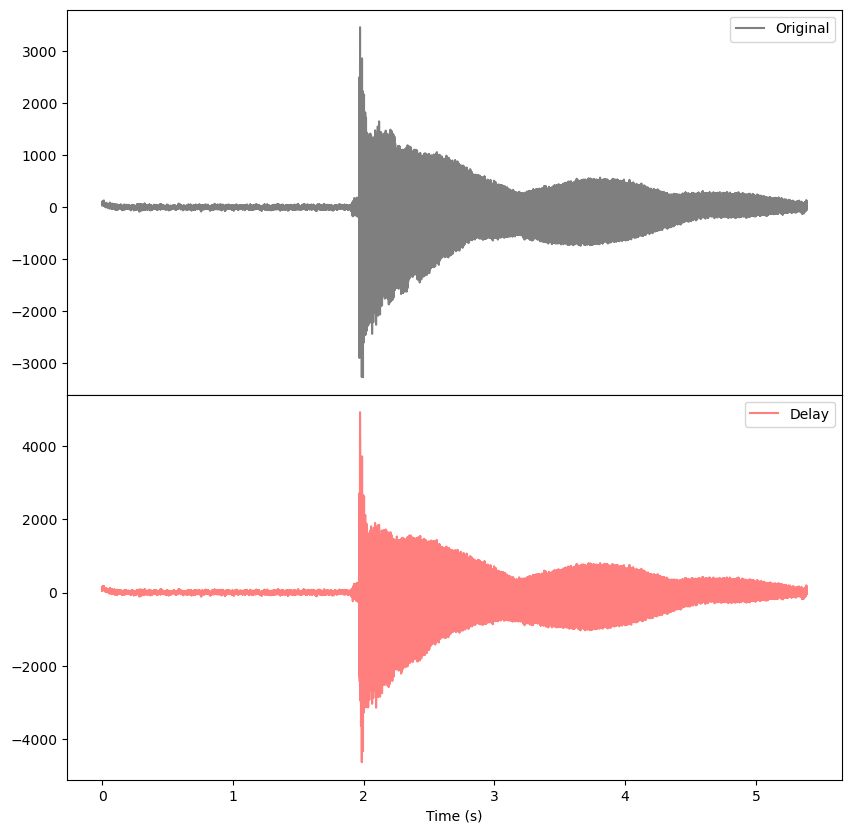

In [14]:
# Plotting
t = np.linspace(0, len(audio)/sr, len(audio))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': 0})

ax1.plot(t, audio, label='Original', alpha=0.5, c='black')
ax1.legend()
ax2.plot(t, delay, label='Delay', alpha=0.5, c='red')
plt.legend()

plt.xlabel('Time (s)')
plt.show()

### Frequency domain interpretation

In [15]:
def fourier_transform(signal):
    N = len(signal)
    T = 1.0 / sr
    yf = fft(signal)
    xf = fftshift(fftfreq(N, T))
    return xf, fftshift(yf)

In [16]:
xf, og_transform = fourier_transform(audio)
xf, delay_transform = fourier_transform(delay)

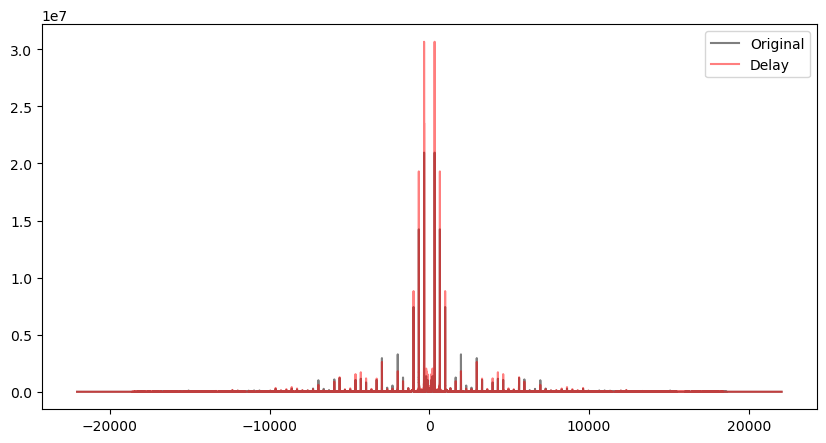

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(og_transform), label='Original', alpha=0.5, c='black')
plt.plot(xf, np.abs(delay_transform), label='Delay', alpha=0.5, c='red')
plt.legend()
plt.show()

We don't see a clear patter of frequencies that are amplified or damped. We will se this clearly in the next section, since the frequency response of the filter is a cosine function, it oscilates with respect to the frequencies it increases or diminishes.

### 2. Frequency response

In [19]:
# Constructing the filter array
filter = np.zeros(DELAY+1)
filter[0] = 1
filter[-1] = ALPHA

In [20]:
filter_freq, filter_trans = freqz(filter, worN=len(audio), fs=sr)

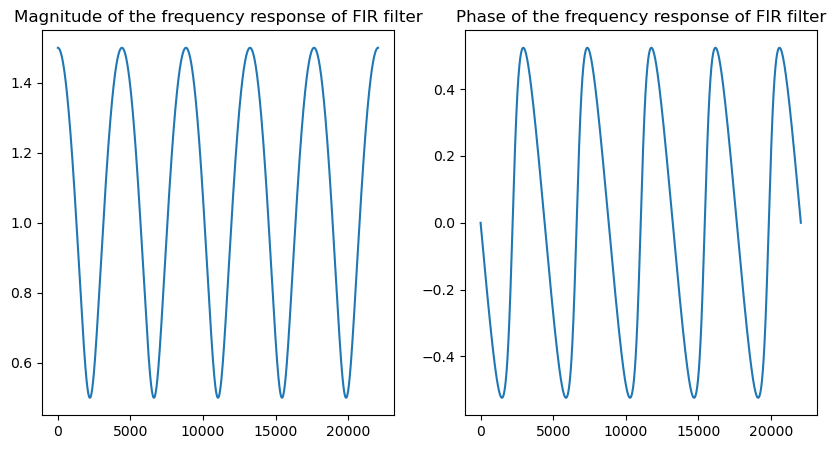

In [27]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(filter_freq, np.abs(filter_trans))
plt.title('Magnitude of the frequency response of FIR filter')

plt.subplot(1, 2, 2)
plt.plot(filter_freq, np.angle(filter_trans))
plt.title('Phase of the frequency response of FIR filter')
plt.show()

## IIR delay

In [18]:
ALPHA = 1
BETA = 0.5

In [20]:
def delay_filter_iir(audio, delay=DELAY, alpha=ALPHA, beta=BETA):
    new_audio = np.zeros(len(audio))
    # For the first `delay` frames, we just copy the original audio multiplied by alpha
    new_audio[:delay] = alpha*audio[:delay]
    for i in range(delay, len(audio)):
        # For the rest of the frames, we use the recursive formula
        new_audio[i] = alpha*audio[i] + beta*new_audio[i-delay]
    
    return new_audio

### 1. Impulse response with D=1

The general framework of IIR filters is given by the equation:

$$
y[t] = \sum_{n=0}^{M} b[n] x[t-n] - \sum_{n=1}^{N} a[n] y[t-n]
$$

To formulate our filter in these terms we can take $M=0$ and $N=1$. This means that $b[0] = \alpha$ and $a[0]=0$, $a[1]=-\beta$ so we can recover the equation 
$$s[t] = \alpha e[t] + \beta s[t-1]$$

In [21]:
impulse_response_iir = delay_filter_iir(delta)

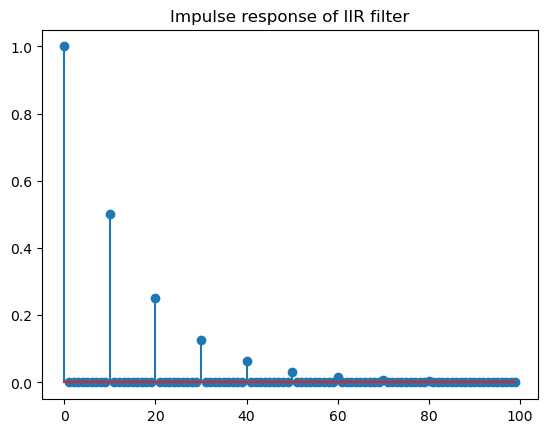

In [22]:
plt.stem(impulse_response_iir[:100])
plt.title('Impulse response of IIR filter')

plt.show()

### 2. Frequency response of the filter

In [23]:
a = np.array([1]+[0]*(DELAY-1)+[-BETA])
b = np.array([ALPHA])

filter_freq, filter_trans = freqz(b, a=a, worN=len(audio), fs=sr)

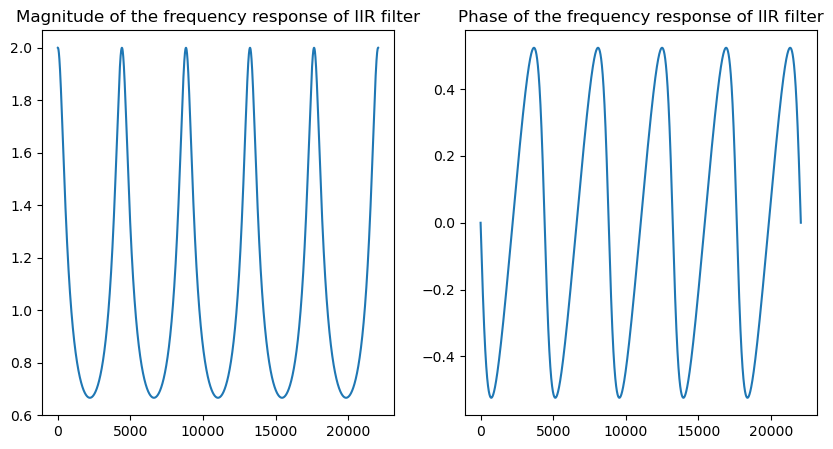

In [24]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(filter_freq, np.abs(filter_trans))
plt.title('Magnitude of the frequency response of IIR filter')

plt.subplot(1, 2, 2)
plt.plot(filter_freq, np.angle(filter_trans))
plt.title('Phase of the frequency response of IIR filter')
plt.show()

### 3. Implementing the filter

In [25]:
delay = delay_filter_iir(audio)

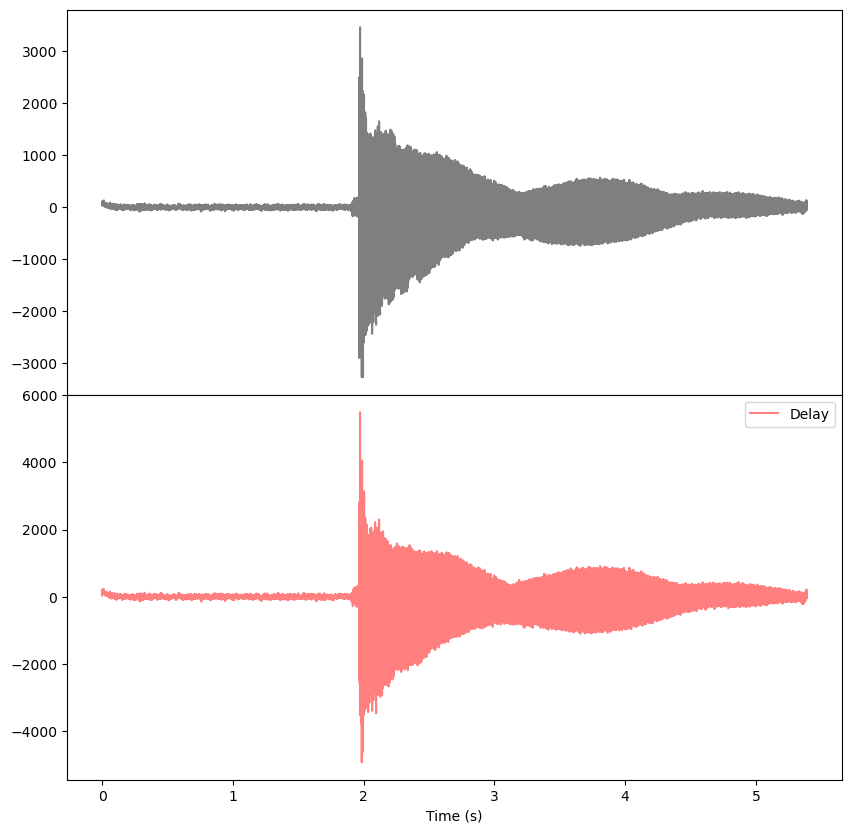

In [26]:
# Plotting
t = np.linspace(0, len(audio)/sr, len(audio))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': 0})

ax1.plot(t, audio, label='Original', alpha=0.5, c='black')
ax2.plot(t, delay, label='Delay', alpha=0.5, c='red')
plt.legend()

plt.xlabel('Time (s)')
plt.show()

In [27]:
xf, og_transform = fourier_transform(audio)
xf, delay_transform = fourier_transform(delay)

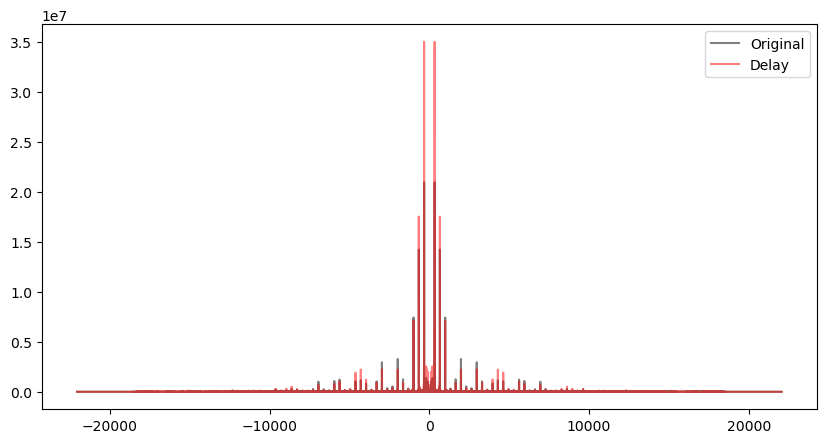

In [28]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(og_transform), label='Original', alpha=0.5, c='black')
plt.plot(xf, np.abs(delay_transform), label='Delay', alpha=0.5, c='red')
plt.legend()
plt.show()

Again, this filter is not trivial to interpret in the frequency domain as a low-pass or high-pass filter. As seen in the previous section, it also oscillates but this time it's not a simple cosine function.

### 4. Stability?

The implementation is not always stable because there could be cases where the output signal grows exponentially and diverges. One such case is when $\beta\gt 1$ and there's a positive input signal.

Doing a bit of math we found a direct relationship between the output and the input of the filter, given by:

$$
s[n] = \alpha\sum_{d=0}^{n} \beta^{d} e[n-d].
$$

This can diverge very quickly for a large n and $\beta\gt1$.

We can see this numerically by inputting the Dirac delta with a large value of $\beta$

In [29]:
filtered_delta = delay_filter_iir(delta, delay=1000, alpha=0.5, beta=1.5)

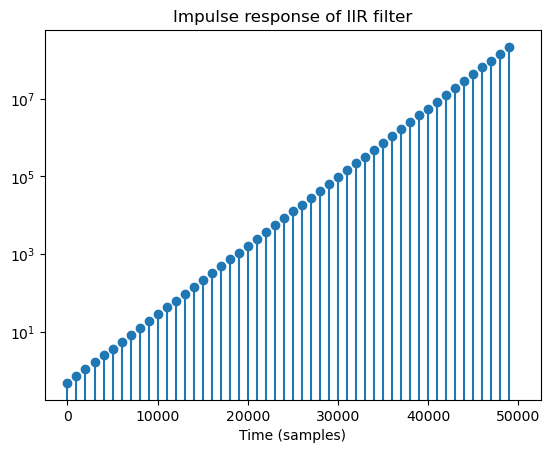

In [30]:
plt.stem(filtered_delta[:50000])
plt.yscale('log')
plt.title('Impulse response of IIR filter')
plt.xlabel('Time (samples)')
plt.show()

### 5.  Parameters?

The $\alpha$ term in the equation controls how much of the current value of the signal adds to the output, whereas $\beta$ gives you the contribution of the previous value of the output to the current one. Higher values of $\alpha$ in comparison to $\beta$ give signals that behave more similarly with the original signal, whereas a higher $\beta$ corresponds to a filter that tends to echo the input many times without incorporating new information.  

### 6. Comparison

We can see from the impulse response examples that we plotted for different values of $\beta$ and $\alpha$ that this filter repeats the signal several times with a strength that can decrease or increase depending on the parameters. The increasing case will inevitably lead to a divergence in the output, and in our numerical simulations an floating point overflow.  On the other hand, the FIR filter just echoes the signal one time. Given this, as long as $\alpha$ is finite, the output will not diverge.

A more practical aspect of these filters is their code implementation. The IIR filter has the problem that it cannot be vectorized in Python, so it requires a for loop which will be much slower than the vectorized implementation of the FIR. To see how much slower we used the ```%%timeit``` magic function of Jupyter so to get an estimate of the time it takes to each filter to run. Based on the results on our devices, we can say that the IIR filter is 3 orders of magnitude slower that the FIR one. 

In [104]:
%%timeit 

delay_filter_fir(audio)

408 µs ± 99.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [105]:
%%timeit 

delay_filter_iir(audio)

448 ms ± 9.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
